## Part 1 - Bootstraping

In [85]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy.stats import norm, t
from sklearn.utils import resample
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from itertools import combinations
from collections import defaultdict
from math import comb

import warnings
warnings.filterwarnings('ignore')

In [38]:
df = pd.read_csv('framingham_heart_disease.csv')

### Section 1
Reminder from previous part:<br>
We would like to explore the relations between: Number of cigaretes per day (discrete), total cholesterol (continous), diaBP (diastolic BP) and sysBP (systolic BP - continous). <br>
Hence, our research question would be:
**What are the effects of number of cigaretes per day, total cholesterol and diaBP over sysBP**

Preparing the subset that we will work with, as done in part 3

In [3]:
df.dropna(subset=['cigsPerDay', 'totChol', 'diaBP', 'sysBP'], inplace=True)
df_train, df_test, y_train, y_test = train_test_split(df[['cigsPerDay', 'totChol', 'diaBP']], df[['sysBP']], test_size=0.9519115171916326, random_state=42)

#### section a - calculating confidence intervals based on the variance matrix and normal approximation 
Calculating the parameters

In [4]:
X = sm.add_constant(df_train)
model = sm.OLS(y_train,X)
model_res = model.fit()
model_res.params

const        -6.795017
cigsPerDay   -0.002428
totChol       0.055739
diaBP         1.520925
dtype: float64

In [5]:
# Since the variance is unknown we will compute it using the unbiased estimator as shown in tutorial 5
dof = len(df_train)-2
sigma_squared = np.dot(model_res.resid.to_numpy().T,model_res.resid.to_numpy())/(len(df_train)-4)
ci_t_percentile = norm().ppf(0.95)
C = np.linalg.inv(np.matmul(X.T,X))  # C = (X.T * X)^-1

In [6]:
for i, beta in enumerate(model_res.params):
    print(f"Confidence interval for beta_{i} is: [{beta - ci_t_percentile*np.sqrt(sigma_squared*C[i,i])},{beta + ci_t_percentile*np.sqrt(sigma_squared*C[i,i])}]")

Confidence interval for beta_0 is: [-20.120873608415256,6.530840172599756]
Confidence interval for beta_1 is: [-0.12499805793941617,0.12014199808401856]
Confidence interval for beta_2 is: [0.024470264676291688,0.0870084154537871]
Confidence interval for beta_3 is: [1.3755587622140237,1.6662906536246527]


#### section b - confidence intervals based on bootsrtap standart error

In [7]:
def cal_bootstrap_normal_se(B, df, features_cols, label_cols):
    df_len = len(df)
    num_param = len(df.columns)
    param_sum = np.zeros((num_param))
    param_sum2 = np.zeros((num_param))
    for i in range(B):
        boot_df = df.sample(replace=True, n=200)
        y = boot_df[label_cols]
        X = boot_df[features_cols]
        X['const'] = np.ones((df_len))
        X = X[['const', *features_cols]]
        model = sm.OLS(y,X)
        model_res = model.fit()
        param_sum = param_sum + model_res.params
        param_sum2 = param_sum2 + (model_res.params) ** 2
    return np.sqrt((1/B)*(param_sum2) - ((1/B)*(param_sum))**2)
        

In [8]:
bootstrap_se = cal_bootstrap_normal_se(400, pd.concat([df_train, y_train], axis=1),
                        features_cols=['cigsPerDay', 'totChol', 'diaBP'], label_cols=['sysBP'])

In [9]:
for i, beta in enumerate(model_res.params):
    print(f"Confidence interval based on bootstrap s.e for beta_{i} is: [{beta - ci_t_percentile*bootstrap_se[i]},{beta + ci_t_percentile*bootstrap_se[i]}]")

Confidence interval based on bootstrap s.e for beta_0 is: [-23.542740732989007,9.952707297173507]
Confidence interval based on bootstrap s.e for beta_1 is: [-0.12959280883386196,0.12473674897846435]
Confidence interval based on bootstrap s.e for beta_2 is: [0.019858342916366845,0.09162033721371193]
Confidence interval based on bootstrap s.e for beta_3 is: [1.341314993151291,1.7005344226873853]


#### section c - pivotals confidence intervals 

In [10]:
def cal_boot_pivot_quantile(B, df, features_cols, labels_cols, alpha):
    num_sample = len(df)
    q = 1 - alpha/2
    g_dict = defaultdict(list)
    q_list = [0] *(len(features_cols) + 1)
    # calculate the real sample param
    X = df[features_cols]
    X['const'] = np.ones((num_sample))
    X = X[['const', *features_cols]]
    Y = df[labels_cols]
    model = sm.OLS(Y, X)
    model_res = model.fit()
    b_r = model_res.params
    for i in range(B):
        new_df = df.sample(num_sample, replace=True)
        X = new_df[features_cols]
        X['const'] = np.ones((num_sample))
        X = X[['const', *features_cols]]
        Y = new_df[labels_cols]
        model = sm.OLS(Y, X)
        model_res = model.fit()
        for i in range(len(features_cols) + 1):
            g_dict[i].append((num_sample*0.5)*(model_res.params[i] - b_r[i]))
    for i in range(len(features_cols) + 1):
        q_list[i] = (np.quantile(g_dict[i], q), np.quantile(g_dict[i], alpha/2))
    return q_list

In [11]:
qunatiles_list = cal_boot_pivot_quantile(400, pd.concat([df_train, y_train], axis=1),
                        features_cols=['cigsPerDay', 'totChol', 'diaBP'], labels_cols=['sysBP'], alpha=0.05)

In [12]:
for i, beta in enumerate(model_res.params):
    print(f"Pivotal confidence intervals based on bootstrap for beta_{i} is: [{beta - qunatiles_list[i][0]/np.sqrt(len(df_train))},{beta - qunatiles_list[i][1]/np.sqrt(len(df_train))}]")

Pivotal confidence intervals based on bootstrap for beta_0 is: [-138.0586917374247,131.23822779070602]
Pivotal confidence intervals based on bootstrap for beta_1 is: [-1.0832803852894608,1.111089548849349]
Pivotal confidence intervals based on bootstrap for beta_2 is: [-0.23327427315486043,0.33911763317189014]
Pivotal confidence intervals based on bootstrap for beta_3 is: [-0.005191028393482844,2.948094563834462]


### Section 2 - confidence intervals based on quantiles method

In [13]:
def cal_boot_quantile(B, df, features_cols, labels_cols, alpha):
    num_sample = len(df)
    q1 = 1 - (alpha / 2)
    q2 = alpha / 2
    g_dict = defaultdict(list)
    q_list = [0] * (len(features_cols) + 1)
    for i in range(B):
        new_df = df.sample(num_sample, replace=True)
        X = new_df[features_cols]
        X['const'] = np.ones((num_sample))
        X = X[['const', *features_cols]]
        Y = new_df[labels_cols]
        model = sm.OLS(Y, X)
        model_res = model.fit()
        for i in range(len(features_cols) + 1):
            g_dict[i].append(model_res.params[i])
    for i in range(len(features_cols) + 1):
        q_list[i] = (np.quantile(g_dict[i], q2), np.quantile(g_dict[i], q1))
    return q_list

In [14]:
confidence_intervals = cal_boot_quantile(400, pd.concat([df_train, y_train], axis=1),
                        features_cols=['cigsPerDay', 'totChol', 'diaBP'], labels_cols=['sysBP'], alpha=0.05)

In [15]:
for i, ci in enumerate(confidence_intervals):
    print(f"Quantiles confidence intervals based on bootstrap for beta_{i} is: [{ci[0]},{ci[1]}]")

Quantiles confidence intervals based on bootstrap for beta_0 is: [-25.348510798637616,12.75725090750684]
Quantiles confidence intervals based on bootstrap for beta_1 is: [-0.15639518781037343,0.13430742119099504]
Quantiles confidence intervals based on bootstrap for beta_2 is: [0.01718658005617239,0.09174186380642317]
Quantiles confidence intervals based on bootstrap for beta_3 is: [1.298264569799994,1.7317618337427316]


**Calculating the parameters using the whole dataset**

In [16]:
X = sm.add_constant(df[['cigsPerDay', 'totChol', 'diaBP']])
model = sm.OLS(df[['sysBP']],X)
model_res = model.fit()
model_res.params

const         5.611044
cigsPerDay   -0.082200
totChol       0.040282
diaBP         1.422623
dtype: float64

### Comparing the confidence intervals

**Confidence intervals for $\beta_0$**:<br>
Confidence interval for beta_0 is: [-20.120873608415245,6.530840172599772]<br>
Confidence interval based on bootstrap s.e for beta_0 is: [-23.24972522909058,9.659691793275108]<br>
Pivotal confidence intervals based on bootstrap for beta_0 is: [-159.0955329137899,127.2672041798435]<br>
Quantiles confidence intervals based on bootstrap for beta_0 is: [-28.044054623349616,9.120851869597175]<br>

As we can see, the smallest interval was given by the normal approximation using the variance matrix.
The next shortest interval was given by the qunatiles method, after that the confidence interval based on bootstrap s.e estimation and finally the pivotal condifence interval is the largest. <br>
All of the confidence intervals contains the parameter $\beta_0$

**Confidence intervals for $\beta_1$**:<br>
Confidence interval for beta_1 is: [-0.12499805793941654,0.12014199808401821] (0.24514) <br>
Confidence interval based on bootstrap s.e for beta_1 is: [-0.12157323646605833,0.11671717661066] (0.23829)<br>
Pivotal confidence intervals based on bootstrap for beta_1 is: [-1.0780884830760757,1.1102611332927885] (2.18835)<br>
Quantiles confidence intervals based on bootstrap for beta_3 is: [-0.16041141204810144,0.1417458305429191] (0.30215) <br>
 
This time the confidence interval given by the boostrap s.e estimation was the smallest, the next shortest interval was given by the normal approximation using the variance method. In a small gap behind them is the interval given by quantiles method and last but not least is the interval given by the pivot method. <br>
All of the confidence intervals contains the parameter $\beta_1$

**Confidence intervals for $\beta_2$**:<br>
Confidence interval for beta_2 is: [0.024470264676292097,0.08700841545378751] (0.06253) <br>
Confidence interval based on bootstrap s.e for beta_2 is: [0.021400344513457188,0.09007833561662243] (0.0686) <br>
Pivotal confidence intervals based on bootstrap for beta_2 is: [-0.1950850780216041,0.36993707354491834] (0.565) <br>
Quantiles confidence intervals based on bootstrap for beta_2 is: [0.01591730129880664,0.09482804535626096] (0.0789) <br>
 
The shortest interval is given by the normal approximation method, the next shortest is the interval based on the bootstrap s.e estimation . Right after that is the interval based on the qunatile method and finally is the interval based on the pivot method. <br>
All of the confidence intervals contains the parameter $\beta_2$

**Confidence intervals for $\beta_3$**:<br>
Confidence interval for beta_3 is: [1.3755587622140237,1.6662906536246527] (0.29074) <br>
Confidence interval based on bootstrap s.e for beta_3 is: [1.3426202113096413,1.6992292045290351] (0.35662) <br> 
Pivotal confidence intervals based on bootstrap for beta_3 is: [-0.017978470252370204,3.0708637474471248] (3.0887)<br>
Quantiles confidence intervals based on bootstrap for beta_3 is: [1.3396107610635424,1.7668155629224438] (0.42719) <br>
    
The shortest interval is given by the normal approximation method, the next shortest is the interval based on the bootstrap s.e estimation . Right after that is the interval based on the qunatile method and finally is the interval based on the pivot method. <br>
All of the confidence intervals contains the parameter $\beta_3$

### Section 3

#### Section a

In [17]:
new_df = pd.concat([df_test, y_test], axis=1).sample(100)

In [18]:
y_test_100 = new_df[['sysBP']]
new_df = new_df[['cigsPerDay', 'totChol', 'diaBP']]

In [19]:
X = sm.add_constant(new_df)

In [20]:
y_new_preds = model_res.predict(X)

#### Section b

In [21]:
def cal_bootstrap_normal_se_predict(B, df_train, X_test, features_cols, labels_cols):
    df_test_len = len(X_test)
    df_train_len = len(df_train)
    predict_sum = np.zeros((df_test_len))
    predict_sum2 = np.zeros((df_test_len))
    for i in range(B):
        boot_df = df_train.sample(replace=True, n=200)
        y = boot_df[labels_cols]
        X = boot_df[features_cols]
        X['const'] = np.ones((df_train_len))
        X = X[['const', *features_cols]]
        model = sm.OLS(y,X)
        model_res = model.fit()
        predict_sum = predict_sum + model_res.predict(X_test)
        predict_sum2 = predict_sum2 + (model_res.predict(X_test)) ** 2
    return np.sqrt((1/B)*(predict_sum2) - ((1/B)*(predict_sum))**2)

In [22]:
y_preds_se = cal_bootstrap_normal_se_predict(400, pd.concat([df_train, y_train], axis=1),
                        X, features_cols=['cigsPerDay', 'totChol', 'diaBP'], labels_cols=['sysBP'])

In [23]:
y_new_cis = [(y_pred - ci_t_percentile*y_pred_se, y_pred + ci_t_percentile*y_pred_se)
              for (y_pred, y_pred_se) in zip(y_new_preds, y_preds_se)]

In [24]:
sum([y_new_ci[0] < y_new[0] < y_new_ci[1] for (y_new, y_new_ci) in zip(y_test_100.values, y_new_cis)])/100

0.26

### Trying to calculate confidence intervals in quantiles method

In [25]:
def cal_bootstrap_quantile_predict(B, df_train, X_test, features_cols, labels_cols, alpha=0.05):
    df_test_len = len(X_test)
    df_train_len = len(df_train)
    q1 = alpha / 2
    q2 = 1 - q1
    predict_dict = defaultdict(list)
    q_list = [0] * (df_test_len)
    for i in range(B):
        boot_df = df_train.sample(replace=True, n=200)
        y = boot_df[labels_cols]
        X = boot_df[features_cols]
        X['const'] = np.ones((df_train_len))
        X = X[['const', *features_cols]]
        model = sm.OLS(y,X)
        model_res = model.fit()
        pred = model_res.predict(X_test)
        for j in range(df_test_len):
            predict_dict[j].append(pred.iloc[j])
    for i in range(df_test_len):
        q_list[i] = (np.quantile(predict_dict[i], q1), np.quantile(predict_dict[i], q2))
    return q_list

In [26]:
y_pred_ci = cal_bootstrap_quantile_predict(400, pd.concat([df_train, y_train], axis=1),
                        X, features_cols=['cigsPerDay', 'totChol', 'diaBP'], labels_cols=['sysBP'])

#### Section c

In [27]:
sum([y_new_ci[0] < y_new[0] < y_new_ci[1] for (y_new, y_new_ci) in zip(y_test_100.values, y_pred_ci)])/100

0.26

#### Section d

We seen in class that the confident interval for the $Y_{new}$ is $[\hat{Y_{new}}\pm z_{1-\frac{\alpha}{2}}\hat{\sigma_{\epsilon}}\sqrt{1+X_{new}^T(X^TX)^{-1}X_{new}}]$. The idea behind this modification in the confident interval is that we adding the estimator of the variance of the data to the variance of our model, which make the confident interval longer. So if we want to build a confident interval base of Bootstrap, we would make a small modification in our current Bootstrap confident interval : $[\hat{Y^i}_{new}\pm z_{\frac{\alpha}{2}}\hat{S.E}_{bootstrap}], \ when \ \hat{S.E}_{bootstrap}^2=\underbrace{\frac{1}{B}\sum_{j=1}^{B}\hat{(Y^j)^2}_{new}-\frac{1}{B}(\sum_{j=1}^{B}\hat{(Y^j)}_{new})^2 }_{variance \ of \ the \ model}+\underbrace{\frac{1}{B}\sum_{j=1}^{B}\hat{\sigma^2_j}_{\epsilon}}_{estimator \ to \ the \ model \ variance} $  

## Part 2 

In [41]:
df = pd.read_csv('framingham_heart_disease.csv')
df.dropna(subset=['BMI', 'male'], inplace=True)

## 1. Hypothesis question:

Let's denote $BMI_{male}$ as the BMI of a random male and $BMI_{female}$ as the BMI of a random female.<br> Our Hypothesis question is : BMI of a male is sthochstic greeter then BMI of a female i.e : $BMI_{male} \ \succ BMI_{female}$

Text(0.5, 1.0, 'Female')

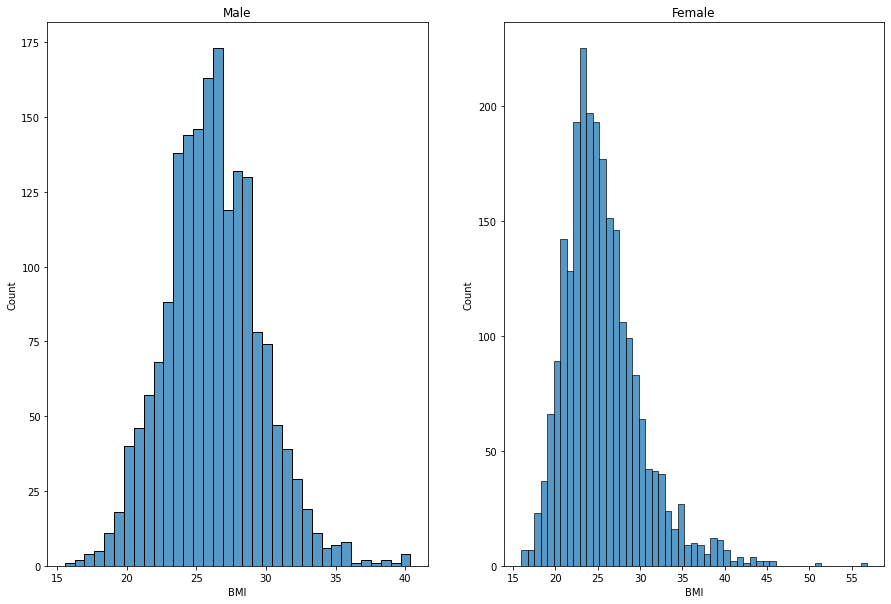

In [42]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
sns.histplot(data=df[df['male']== 1], x='BMI', ax=axes[0]).set_title('Male')
sns.histplot(data=df[df['male']== 0], x='BMI', ax=axes[1]).set_title('Female')

From the first look on he histogram we can infer that the answer to our hypothesis question is true.

## section 2

In [50]:
male_train, male_test, bmi_train, bmi_test = train_test_split(df[['male']], df[['BMI']], test_size=4019/4219, random_state=42)

## section 3

## a

In [51]:
male_bmi_train = pd.concat([male_train, bmi_train], axis=1)

In [69]:
male_bmi = male_bmi_train[male_bmi_train["male"] == 1]["BMI"]
female_bmi = male_bmi_train[male_bmi_train["male"] == 0]["BMI"]

In [70]:
male_bmi_avg = male_bmi.mean()
female_bmi_avg = female_bmi.mean()

In [71]:
male_bmi_avg

26.33636363636364

In [72]:
female_bmi_avg

25.902321428571433

In [73]:
male_bmi_avg - female_bmi_avg

0.43404220779220637

We denote male bmi mean as $\mu_1$ and female bmi mean as $\mu_2$. We can see that $\mu_1$=26.3 and $\mu_2$=25.9. Futhermore $\delta$ = 0.43. <br>Our estimator is not a MLE estimator becuase it's calculate only from a partical samples from our observed data and not all the observed data.

## b

In [ ]:
# TODO : check if we need to estimate CI by bootstrap or other method 

## c

In [ ]:
# TODO : because the previaous section

## d

Wald test :<br>          $H_0 \ \mu_1=\mu_2$          <br>$H_0 \ \mu_1\ne\mu_2$          <br>T.S:$\frac{|\mu_1-\mu_2|}{\hat{s.e}}$

In [78]:
test_var = ((male_bmi.std())**2/len(male_bmi)) + ((female_bmi.std())**2/len(female_bmi))
test_stat = abs(male_bmi_avg - female_bmi_avg) / (test_var)**0.5
pval_wald = 2*norm.cdf(-test_stat)

In [79]:
pval_wald

0.4433246746970879

Permutation Test:<br>$H_0:BMI_{male} \ = BMI_{female}$<br> $H_1:BMI_{male} \ \succ BMI_{female}$<br>T.S:$\mu_{male}-\mu_{female}$<br>$Pvalue=\frac{\#\mathbb{1}\{T_j>=T_0\}}{{n+m \choose n}}$

In [86]:
perm_test_stat = male_bmi_avg - female_bmi_avg
counter = 0
for bmi_combi in combinations(male_bmi_train["BMI"].values, len(male_bmi)):
    mean_bmi = sum(bmi_combi) / len(bmi_combi)
    if mean_bmi >= perm_test_stat:
        counter += 1
pval_perm = counter /comb(len(male_bmi_train["BMI"]), len(male_bmi))

KeyboardInterrupt: 

## section 4

## a

In [88]:
len(male_bmi)

88

In [89]:
comb(200,88)

21534099716856603957288603514012855223601371336107402599000